In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# **Reminder**

*   N : number of samples
*   T : sequence length
*   D : input feature dimensionality
*   M : number of hidden units
*   K : number of output units



# **Generating Data**

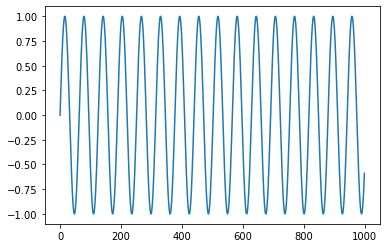

In [ ]:
N = 1000
series = np.sin(0.1*np.arange(N)) # + np.random.randn(N)*0.1

plt.plot(series)
plt.show()

In [ ]:
# for RNN's, we need an N*T*D format with N = number of sequences, T = length of the sequence i.e. number of features
T = 10 # window for predictions
X, Y  = [], []
for t in range(len(series) - T):
  x = series[t:t+T] # 10 data points
  X.append(x)
  y = series[t+T] # point to predict 
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # here -1 acts as a wildcard, it finds a dimension so that dim2 = T and dim3 = 1 
Y = np.array(Y).reshape(-1, 1)
N = len(X)

print("X shape:", X.shape, "\nY shape:", Y.shape)

X shape: (990, 10, 1) 
Y shape: (990, 1)


# **Model architecture**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class SimpleRNN(nn.Module):
  def __init__(self, input_size, hidden_size, n_rnnlayers, out_size):
    super(SimpleRNN, self).__init__()
    self.D = input_size
    self.M = hidden_size
    self.K = out_size
    self.L = n_rnnlayers

    # data shape: (seq_length, n_samples, n_features)
    self.rnn = nn.RNN(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        nonlinearity = 'relu',
        batch_first = True # N dimension comes first
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output, size (N,T,M), 1st value is hidden states indexed by time, 2nd value is hidden states indexed by hidden layer (unused for now)
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step, "many to one" RNN, thus we only select the last value of N
    # N * M becomes N * K
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
model = SimpleRNN(input_size=1, hidden_size=5, n_rnnlayers=1, out_size=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# **Inputs and targets**

In [ ]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32)) # half the data for training
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32)) # half for testing
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# **Full training**

In [ ]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
  train_losses, test_losses = np.zeros(epochs), np.zeros(epochs)

  for it in range(epochs):
    model.zero_grad()

    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # backward 
    loss.backward()
    optimizer.step()

    train_losses[it] = loss.item()

    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = loss.item()

    if (it + 1) % 25 == 0:
      print(f'Epoch {it+1}, train loss: {train_losses[it]:.4f}, test_loss: {test_losses[it]:.4f}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 25, train loss: 0.0166, test_loss: 0.0166
Epoch 50, train loss: 0.0041, test_loss: 0.0041
Epoch 75, train loss: 0.0034, test_loss: 0.0034
Epoch 100, train loss: 0.0029, test_loss: 0.0029
Epoch 125, train loss: 0.0026, test_loss: 0.0026
Epoch 150, train loss: 0.0024, test_loss: 0.0024
Epoch 175, train loss: 0.0021, test_loss: 0.0021
Epoch 200, train loss: 0.0016, test_loss: 0.0016


# **Loss**

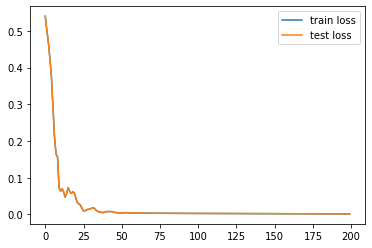

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

# **Forecasting using self-predictions only**

In [ ]:
y_val = Y[-N//2:]
val_predictions = []

# to start the prediction, last sample of training
last_x = X_test[0].view(T)

while len(val_predictions) < len(y_val):
  input_ = last_x.reshape(1, T, 1) # shape N*T*D with N=1 and D=1
  pred = model(input_)
  val_predictions.append(pred[0,0].item()) # output is N*K with N=1 and K=1

  # new input
  last_x = torch.cat((last_x[1:], pred[0]))

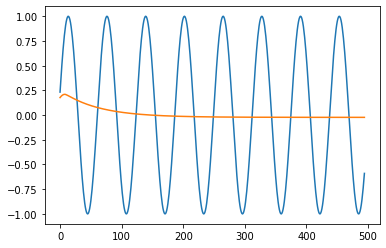

In [ ]:
plt.plot(y_val)
plt.plot(val_predictions)

Currently, the RNN is still too flexible and apparently requires further tuning.